# Applied Social Data Science Capstone Project

  The goal of this project is to apply a set of data science methods to an existing empirical problem. I use two main datasets: Trump tweets for the 2016-2019 period and S&P 500 index for the same period. I intend to investigate whether Trump's tweets have any effect on the index, therefore, on the stock prices. 
  
  To be able to understand whether these tweets have any impact on the stock prices, I decided to include only those tweets that mention the words I find associated with financial market changes. The key words are the following: stock, economy, finance, Fed, trade, tax, bank, exchange, USD, Dollar, money, boom, rate, employment, GDP, inflation, unemployment, China, budget, surplus, oil, NAFTA, gold, Russia, Putin, election, Hillary, Obama. 
    
I intend to divide the analysis into three main parts:
1. Construct time series model for predicting the closing price of the stocks
2. Implement Natural Language Processing (NLP): Sentiment Analysis on the tweet texts
3. Construct RNN (Recurrent Neural Network) or other Deep Learning models for the classification of closing stock price change direction (increase, decrease, no change) relative to previous day

Note: As S&P 500 is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States, I will interchangeably refer to it both as index and as stock price.  

Before any analysis is performed, I need to develop the final dataset, which contains information about the tweet and the index price. Afterwards, careful data cleaning is required to have data in an appropriate format.

# Data pre-processing

First, I am importing neccessary library I will use, which is pandas. Afterwards, the Twitter dataset is imported to the notebook (the dataset is exported from http://www.trumptwitterarchive.com/). Have a quick glance on the data. 

In [1]:
import pandas as pd

In [2]:
# parse_dates is neccessary for python to identify that the varible will indicate time, while encoding type should be changed to
# unicode escape as the default 'utf-8' cannot decode the unrecognizable symbols 

df_tweet=pd.read_csv('Trump.csv', parse_dates=['Date'],encoding = 'unicode_escape')
df_tweet.tail(2)

,source,text,Date,retweet_count,favorite_count,is_retweet,id_str
3063,Twitter for Android,@jallenaip: Hillary said she was in a Fog of W...,2016-01-01,2721,7490,False,6.830000e+17
3064,Twitter for Android,Do you believe that The State Department on NE...,2015-12-31,2755,6824,False,6.830000e+17


Now, importing the index dataset to the notebook. The data was exported from https://finance.yahoo.com/. Again, have a quick look on the data.

In [3]:
df_stock=pd.read_csv('stock.csv', parse_dates=['Date'])
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-30,2077.340088,2077.340088,2061.969971,2063.360107,2063.360107,2367430000
1,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000
2,2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000
3,2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000
4,2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000


As I would like to see whether the direction of the fluctuations of the index are in hand with the emotions expressed in Trump's tweets, there is a neccessity to create new variables, which are the percentage change of the closing price and just the price change of the index. As a result of percentage and difference calculation, the first observation from closing price change is NaN (not a number), and I would like to drop the row which contains NaN. 

In [4]:
df_stock['Change']=df_stock['Close'].pct_change()
df_stock['Difference'] = df_stock['Close'].diff()
df_stock.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Difference
0,2015-12-30,2077.340088,2077.340088,2061.969971,2063.360107,2063.360107,2367430000,NaN,NaN
1,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000,-0.009412,-19.420166


In [5]:
df_stock=df_stock.dropna()
df_stock.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Difference
1,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000,-0.009412,-19.420166
2,2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,-0.015304,-31.279907


Now, I would like to merge this two datasets according to date. This way we can see the daily stock price change of the day a particular tweet was made. 

Afterwards, I create a new variable in our dataframe "Change_bin", which is going to be a binary variable based on the values of 
"Change" column. Whenever the change is positive the value of the binary variable will be 1, otherwise it will be 0 (if the 
price did not change or the change was negative)

In [6]:
df=pd.merge(df_tweet, df_stock, on='Date', how='left')

In [7]:
df['Change_bin'] = '0'
df.loc[(df['Change'] > 0), 'Change_bin'] = '1'
df.head(2)

,source,text,Date,retweet_count,favorite_count,is_retweet,id_str,Open,High,Low,Close,Adj Close,Volume,Change,Difference,Change_bin
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0,True,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0,True,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1


The dataset is ready for the cleaning now. First, let's have a general view over the dataset developed.

All of the variables have the appropriate type, except for "favorite count", as it is supposed to be an intereger, but in 
the output it is specicied as object, thus, there should be some misspecified values. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3065 entries, 0 to 3064
Data columns (total 16 columns):
source            3065 non-null object
text              3061 non-null object
Date              3065 non-null datetime64[ns]
retweet_count     3065 non-null int64
favorite_count    3065 non-null object
is_retweet        3047 non-null object
id_str            3065 non-null float64
Open              2155 non-null float64
High              2155 non-null float64
Low               2155 non-null float64
Close             2155 non-null float64
Adj Close         2155 non-null float64
Volume            2155 non-null float64
Change            2155 non-null float64
Difference        2155 non-null float64
Change_bin        3065 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(5)
memory usage: 407.1+ KB


We see that there are three misspecified values in the column and we would like to drop the rows containing misspecified values.

Additionally, I would like to see how many missing observation we have in the dataset. 

In [9]:
df.loc[~df['favorite_count'].str.isdigit(), 'favorite_count'].tolist()

['FALSE', 'TRUE', 'FALSE']

In [10]:
df= df[~df['favorite_count'].isin(['FALSE', 'TRUE'])]

In [11]:
df.isnull().sum()

source              0
text                4
Date                0
retweet_count       0
favorite_count      0
is_retweet         17
id_str              0
Open              909
High              909
Low               909
Close             909
Adj Close         909
Volume            909
Change            909
Difference        909
Change_bin          0
dtype: int64

It is evident that there are a lot of missing data. We need to develop a strategy to deal with the, 

Important note: there are three important clusters of variables that need attention in terms of discussing missing values.

1. Variable "text", there are four observation missing from it. As the whole analysis will be around the tweet itself, and we cannot assume any value for the missing observation, we will need to drop the rows containing that missing value.

2. Variable "is_retweet". This variable is not going to be included in the model itself, that is why dropping the missing values, thus loosing all those rows is unnecessary. Instead, we can just drop the variable itself now.

3. The third cluster will be the stock prices ("Open", "High", "Low", "Close", "Adj Close", "Volume", "Change"). This missing values are explained by the fact that for some of the dates the tweets were made there is no recorded data for the stock price, i.e. there is no recorded data for the weekend days. As the price of stock is very important for the model, we will need to drop the rows containing missing data. 

In [12]:
df.drop('is_retweet', axis=1, inplace=True)
df.dropna(inplace=True)
df.head(2)

,source,text,Date,retweet_count,favorite_count,id_str,Open,High,Low,Close,Adj Close,Volume,Change,Difference,Change_bin
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1


In [13]:
# just make sure we do not have any missing value anymore
df.isnull().sum()

source            0
text              0
Date              0
retweet_count     0
favorite_count    0
id_str            0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Change            0
Difference        0
Change_bin        0
dtype: int64

Have a quick look at the descriptive statistics of the numerical variables we have in the dataset

In [14]:
df.describe()

,retweet_count,id_str,Open,High,Low,Close,Adj Close,Volume,Change,Difference
count,2151.000000,2.151000e+03,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000,2.151000e+03,2151.000000,2151.000000
mean,17885.328684,9.765026e+17,2602.217553,2613.480960,2589.549540,2602.121901,2602.121901,3.573938e+09,0.000252,0.416116
std,10121.726608,1.504725e+17,317.257707,318.456038,315.300890,316.412319,316.412319,5.957222e+08,0.008879,23.590020
min,0.000000,6.830000e+17,1833.400024,1864.780029,1812.290039,1851.859985,1851.859985,1.911470e+09,-0.040979,-113.189942
25%,11100.000000,8.390000e+17,2348.214966,2355.219971,2337.629883,2349.250000,2349.250000,3.220250e+09,-0.002443,-6.479980
50%,16997.000000,1.000000e+18,2712.620117,2727.760010,2692.050049,2708.639893,2708.639893,3.485790e+09,0.000753,1.929932
75%,22968.000000,1.120000e+18,2861.930054,2884.969971,2839.639893,2857.050049,2857.050049,3.858150e+09,0.005048,13.610108
max,120661.000000,1.180000e+18,3024.469971,3027.979980,3014.300049,3025.860107,3025.860107,7.609010e+09,0.034336,84.050048


In [15]:
df.tail()

,source,text,Date,retweet_count,favorite_count,id_str,Open,High,Low,Close,Adj Close,Volume,Change,Difference,Change_bin
3043,Twitter for Android,Hank Greenberg formerly of AIG gave $10 millio...,2016-01-08,1968,5390,6.850000e+17,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4.664940e+09,-0.010838,-21.059937,0
3044,Twitter Web Client,Hillary and her friends! https://t.co/q45tTapqMI,2016-01-07,2303,4527,6.850000e+17,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5.076590e+09,-0.023700,-47.170044,0
3045,Twitter for Android,@Kacee50: @realDonaldTrump Women make up the f...,2016-01-06,3142,6693,6.850000e+17,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4.336660e+09,-0.013115,-26.449951,0
3046,Twitter Web Client,Woody Johnson owner of the NYJets is @JebBush...,2016-01-04,4202,8757,6.840000e+17,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4.304880e+09,-0.015304,-31.279907,0
3064,Twitter for Android,Do you believe that The State Department on NE...,2015-12-31,2755,6824,6.830000e+17,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2.655330e+09,-0.009412,-19.420166,0


# 1. Construct time series model (ARIMA) for predicting the closing price of the stocks 

In [16]:
stock=df_stock[["Date", "Close"]]
stock['Date'] = pd.to_datetime(stock['Date'])
stock.set_index('Date', inplace=True)
stock=stock.dropna()

C:\Users\Asus UX310\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


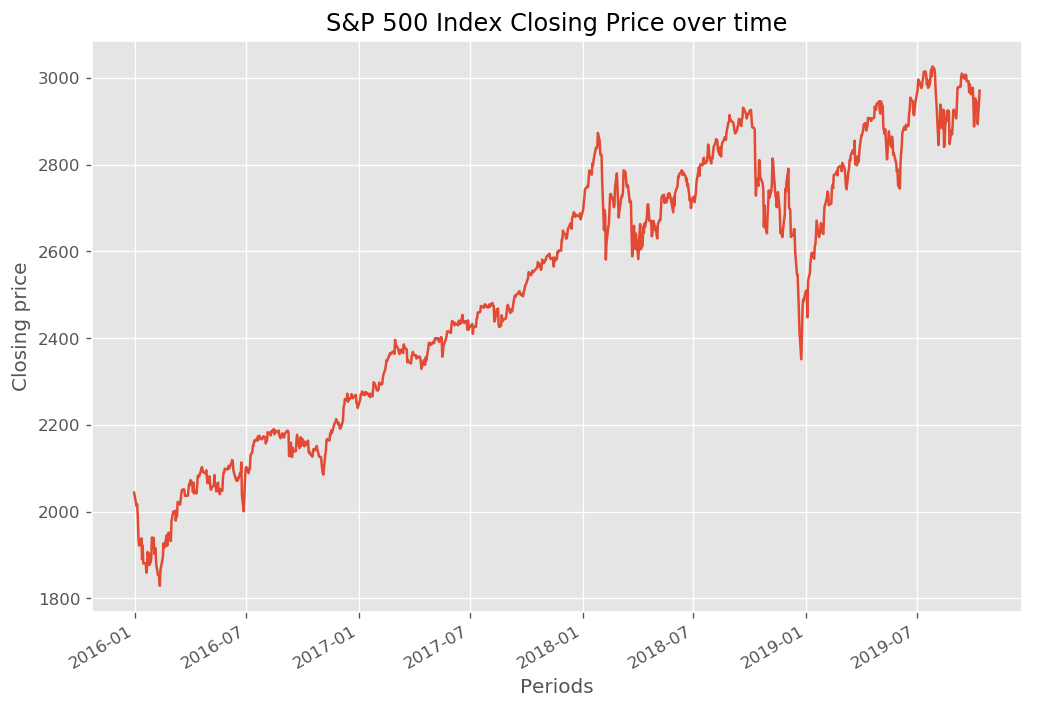

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
plt.style.use('ggplot')
plot=stock.Close.plot()
plot.set_title('S&P 500 Index Closing Price over time')
plot.set_xlabel('Periods')
plot.set_ylabel('Closing price')
plt.show()

First, I am going to check if the series is stationary or not using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package. I need to identify whether the data needs differencing or not. 

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. 

In [18]:
# Calculate AD Fuller statistics 
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_stock['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.407013
p-value: 0.578909


Since p value is way over the significance level, we go ahead with differencing the series and see how the autocorrelation plot looks like. We use first order differencing. 

In [20]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':120})

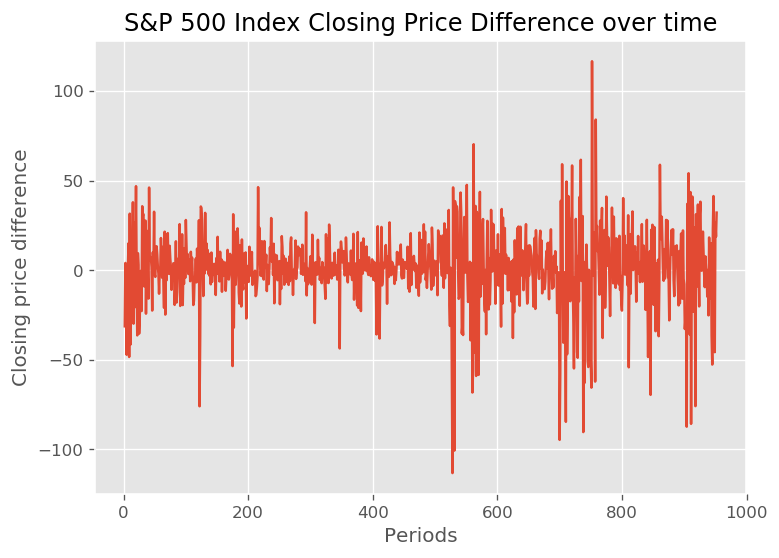

In [21]:
plot=df_stock['Close'].diff().plot()
plot.set_title('S&P 500 Index Closing Price Difference over time')
plot.set_xlabel('Periods')
plot.set_ylabel('Closing price difference')
plt.show()

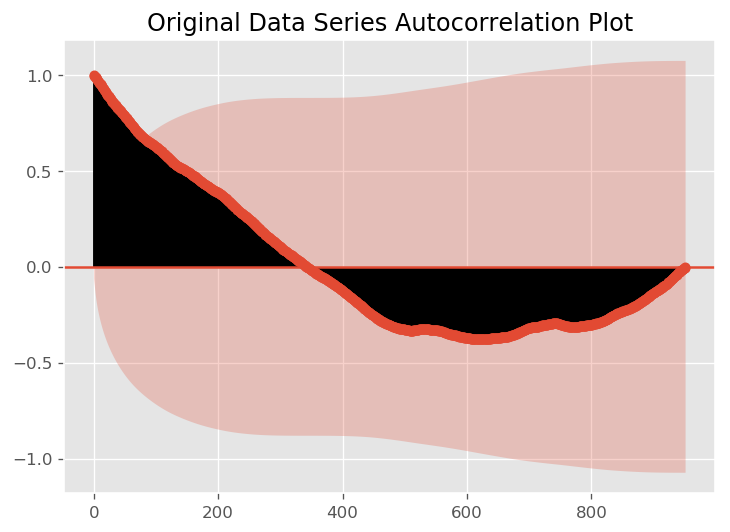

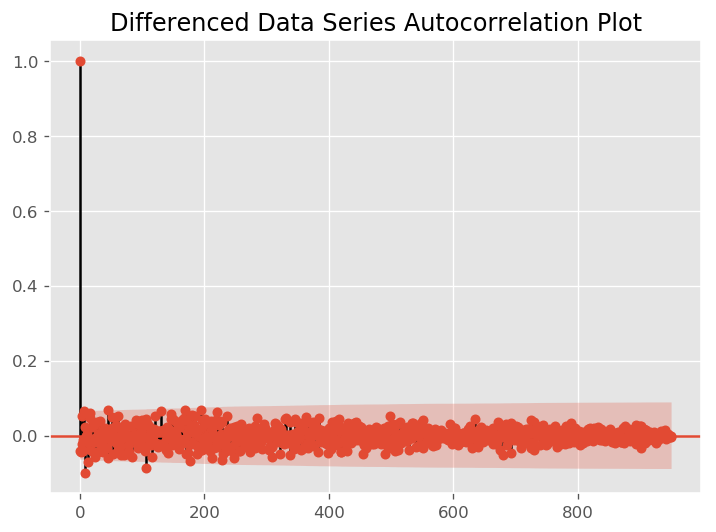

In [22]:
# The first plot refers to the original series
plot_acf(df_stock['Close'],lags=951, title="Original Data Series Autocorrelation Plot")
# The second plot refers to already differenced series
plot_acf(df_stock['Close'].diff().dropna(),lags=950, title="Differenced Data Series Autocorrelation Plot")
plt.show()

In the ACF plots below I choose to show only first 50 lags both for better visualization and in my opinion, these are the lags that should be condisered when discussing differencing.

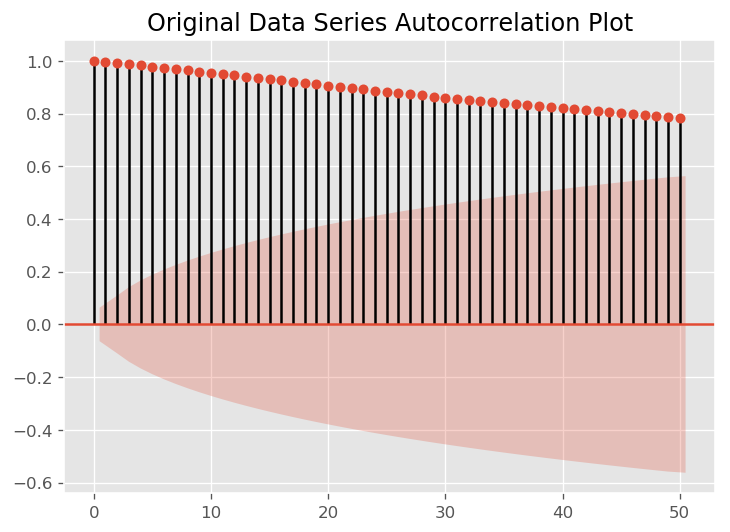

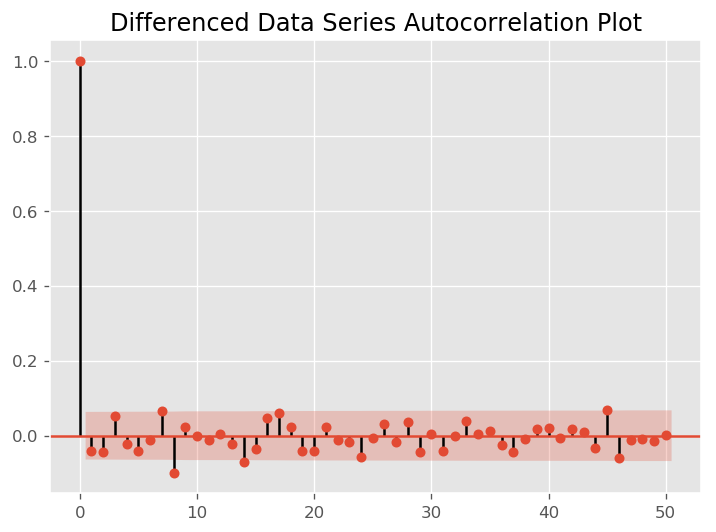

In [23]:
# The first plot refers to the original series
plot_acf(df_stock['Close'],lags=50, title="Original Data Series Autocorrelation Plot")
# The second plot refers to already differenced series
plot_acf(df_stock['Close'].diff().dropna(),lags=50, title="Differenced Data Series Autocorrelation Plot")
plt.show()

The next step is to identify if the model needs any AR terms. We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. From the plot it is not clear at all what the order should be used (both 7th and 8th are very near to the confidence band).

We will first manually perform Arima, and then will try to figure out what are the suggestions of the auto-Arima. 

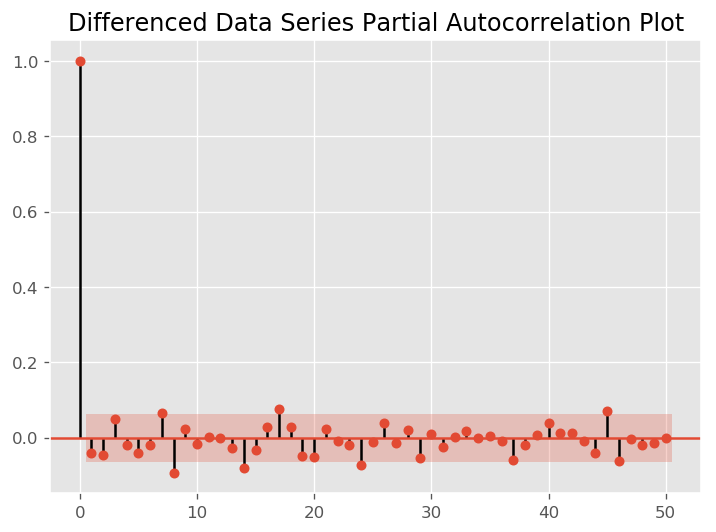

In [24]:
# PACF plot of 1st differenced series
plot_pacf(df_stock['Close'].diff().dropna(),lags=50, title="Differenced Data Series Partial Autocorrelation Plot")
plt.show()

Just like how we looked at the PACF plot for the number of AR terms, we can now look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Looking at both of the graphs, it is hard to decide which lags should be included. We see that the 8th lag is significant, however, it is not logical to include the 8th lag in the model as it will include large timespan. Instead, I will use auto-arima to identify the most efficient model by minimizing AIC/BIC itself. 


In [25]:
import pmdarima as pm
model = pm.auto_arima(df_stock.Close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=8494.473, BIC=8504.188, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=8494.848, BIC=8509.421, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1); AIC=8494.700, BIC=8509.272, Fit time=0.025 seconds
Total fit time: 0.162 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  951
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4245.236
Method:                           css   S.D. of innovations             21.011
Date:                Mon, 04 Nov 2019   AIC                           8494.473
Time:                        02:20:35   BIC                           8504.188
Sample:                             1   HQIC                          8498.174
                                                                              
                 coef    std err  

According to the results, the best suitable model is ARIMA(0,1,0). 
Auto-Arima results are even more puzzling, however, not surprising. Such a simple algorithm as ARIMA will not be able to explain fluctuation in the index prices, as they are dependent on numerous criteria. Later in the 3rd section of this report, we will see much more complex algorithm and test whether it performs well enough. 

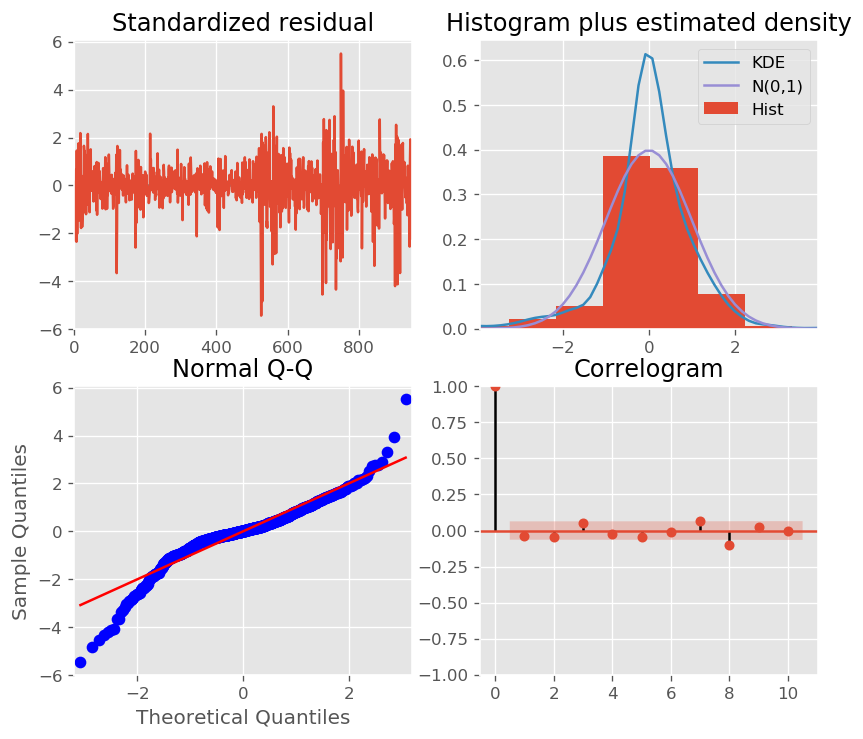

In [26]:
model.plot_diagnostics(figsize=(8,7))
plt.show()

Standardized residual graph:
The residual errors seem to fluctuate around a mean of zero and have a somewhat uniform variance.

Histogram plus estimated density:
The density plot is somewhat normally distributed.

Normal Q-Q.
All the dots should fall  in line with the red line. As it can be noted, this is not the case for our model, thus these significant deviations imply the distribution is skewed.

Correlogram: 
The ACF plot shows the residual errors are not autocorrelated. Only the eighth  one is a little outside the confidence band. Any significant autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model.

__Let’s plot the actuals against the fitted values using plot_predict().__

C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


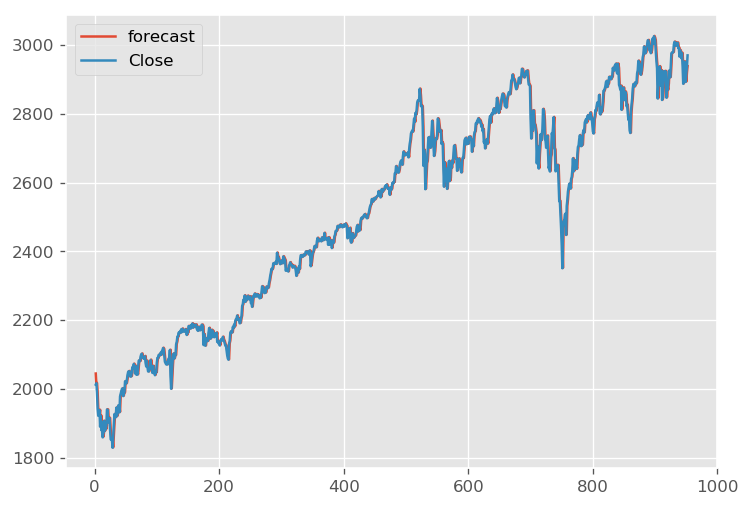

In [27]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_stock.Close, order=(0,1,0))
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.show()

The model gets trained up until the previous value to make the next prediction (because of our setting dynamic=False). This can make the fitted forecast and actuals look artificially good. Now, I need Out-of-Time cross-validation to see whether the model was actually decent.

### ARIMA model manually using Out-of-Time Cross validation

In [28]:
len(df_stock.Close)

952

To do out-of-time cross-validation, we need to create the training and testing dataset by splitting the time series into 2 contiguous parts (75:25 approximately). 

In [29]:
train = df_stock.Close[:700]
test = df_stock.Close[700:]

Now, we build the ARIMA model on training dataset, forecast and plot it.

C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


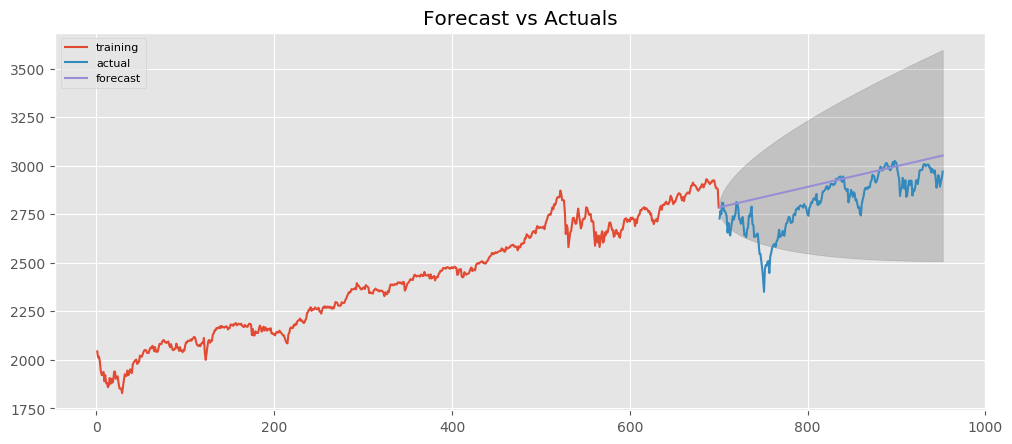

In [30]:
#now build the ARIMA model on training dataset, forecast and plot it
# Build Model ARIMA (0,10)
model = ARIMA(train, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(252, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. 
now, let's use auto_arima(). This function uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

### SARIMA

The problem with plain ARIMA model is it does not support seasonality. If the time series has defined seasonality, then SARIMA should be used, as it uses seasonal differencing.Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

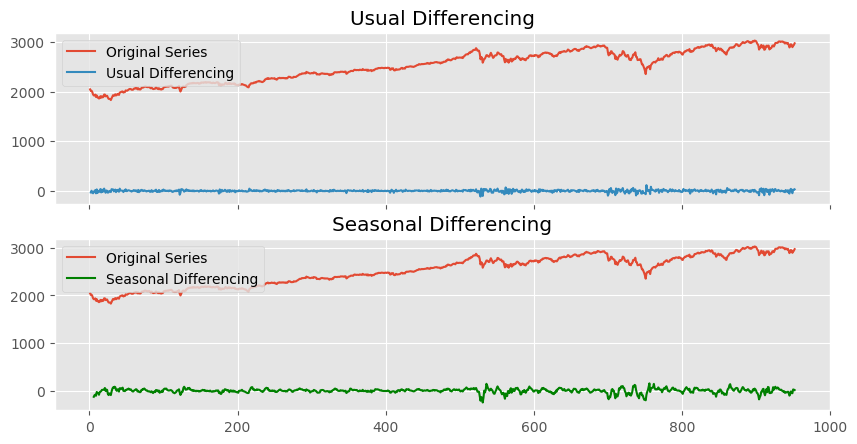

In [33]:
# build an SARIMA
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_stock.Close[:], label='Original Series')
axes[0].plot(df_stock.Close[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df_stock.Close[:], label='Original Series')
axes[1].plot(df_stock.Close[:].diff(5), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.show()

As you can see, the seasonal spikes are ignored after applying usual differencing (lag 1). Whereas, it is accounted for after seasonal differencing.

Let’s build the SARIMA model using pmdarima's auto_arima(). To do that, we set seasonal=True, set the frequency m=5 for workdays series and enforce D=1. 

In [32]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_stock.Close, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 5); AIC=8478.522, BIC=8502.788, Fit time=1.584 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 5); AIC=9890.626, BIC=9900.332, Fit time=0.077 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 5); AIC=8789.353, BIC=8808.766, Fit time=0.660 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 5); AIC=9282.381, BIC=9301.794, Fit time=0.704 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 5); AIC=8478.872, BIC=8507.992, Fit time=2.196 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 5); AIC=9033.930, BIC=9053.343, Fit time=0.447 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 5); AIC=8478.852, BIC=8507.972, Fit time=1.935 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 5); AIC=8481.738, BIC=8515.712, Fit time=4.036 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 5); AIC=8477.079, BIC=8506.199, Fit time=2.091 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  952
Model:             SARIMAX(3, 0, 3)x(0, 1, 1, 5)   Log Likelihood               -4228.584
Date:                           Mon, 04 Nov 2019   AIC                           8475.168
Time:                                   02:21:59   BIC                           8518.848
Sample:                                        0   HQIC                          8491.813
                                           - 952                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1427      0.043      3.354      0.001       0.059       0.226
ar.L1          1.4129      0.034     41.664      0.000       1.346       1.479
ar.L2         -1.3156      0.054    -24.353      0.000      -1.421      -1.210
ar.L3          0.8753      0.037     23.714      0.000       0.803       0.948
ma.L1         -0.4817      0.040    -12.174      0.000      -0.559      -0.404
ma.L2          0.9582      0.031     30.970      0.000       0.898       1.019
ma.L3         -0.0191      0.026     -0.735      0.462      -0.070       0.032
ma.S.L5       -0.9919      0.009   -111.592      0.000      -1.009      -0.974
sigma2       436.5939     12.901     33.842      0.000     411.308     461.880
===================================================================================
Ljung-Box (Q):                       45.61   Jarque-Bera (JB):               962.59
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As we can see from the output that all the variables are statistically significant at 99% confidence interval level, except for 3rd MA lag. Seasonal ARIMA captures the movement better than the ordinary ARIMA. Let's look at forecast numbers for the coming week. As we can see, the numbers are not too distinct from each other. 

In [34]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df_stock.Close,
                                order=(3, 0, 3),
                                seasonal_order=(0, 1, 1, 5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


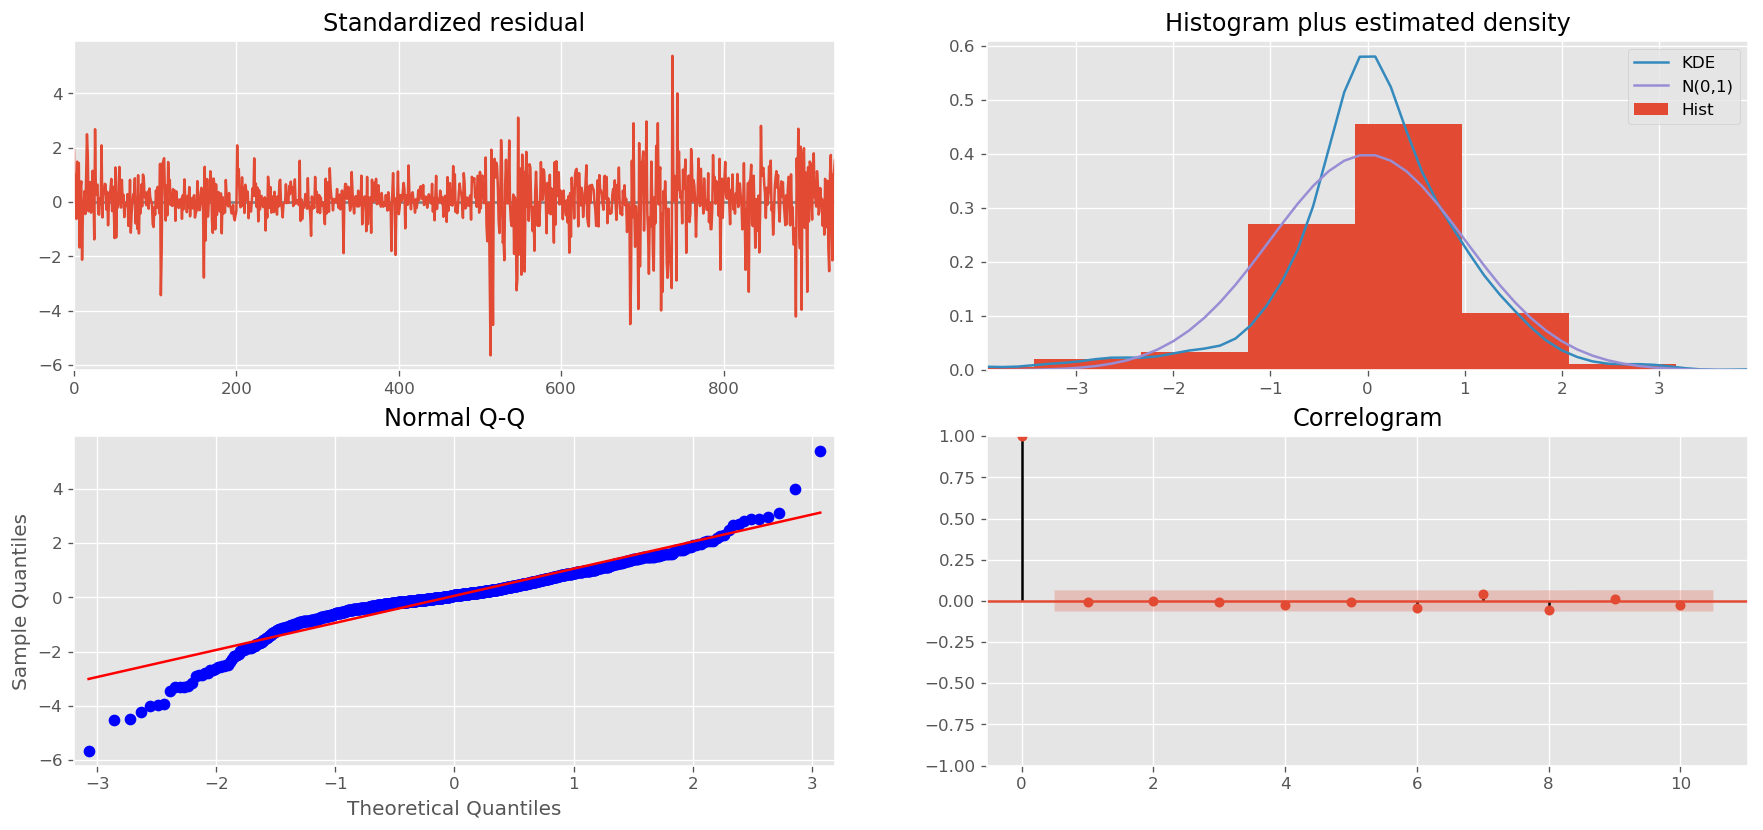

In [35]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [36]:
model_pred = sm.tsa.statespace.SARIMAX(train,
                                order=(3, 0, 3),
                                seasonal_order=(0, 1, 1, 5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
fitted = model_pred.fit()

C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Asus UX310\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


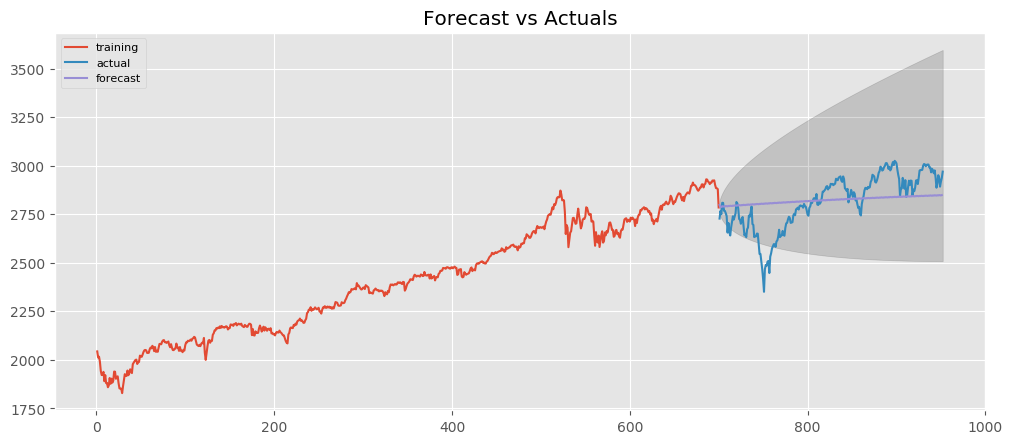

In [37]:
fc = fitted.forecast(252)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

To conclude, constructing ARIMA or SARIMA to predict the closing price of the S&P500 index is too simplistic. The movements in the index are not just explained by itself or shocks, there are numerous factors involved in the formation of the index (CPI, Exchange rate, etc.). This model is just a quick look into the dynamics of the index price. 

Next, I will look in detail at the Trump's tweets dataset to have an initial understanding of it. 

# 2. Implement Natural Language Processing: Sentiment Analysis on the tweet text

First, I would like to create a new dataframe with only the tweets texts. 

In [38]:
data=df[['source','text','Date','retweet_count','favorite_count']]
data.head(2)

,source,text,Date,retweet_count,favorite_count
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0


In [39]:
import time
import ast
import random
import datetime
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.offline import plot,init_notebook_mode, iplot
init_notebook_mode(connected=True)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
pd.set_option('display.max_columns', 50)

In [40]:
data['Date'].dt.date.value_counts().reset_index().sort_values('index').head(2)

,index,Date
540,2015-12-31,1
600,2016-01-04,1


In [41]:
fig = px.line(data['Date'].dt.date.value_counts().reset_index().sort_values('index'), x="index", y="Date")
# Edit the layout
fig.update_layout(title='Historical graph of number of tweets',
                   xaxis_title='Date',
                   yaxis_title='Number of tweets during the day')
fig.show()

From the graph we can observe number of tweets per date. Here we can see clear spikes in the amount of tweets (with relevant keys) on September-October 2016, and then in May, August 2019. 

The first spike is the end of the presidential campaignm right before the 2016 presidential elections. The number of tweets in general was much higher during that period, and the number of tweets concerning financial markets also was high, as I suppose he was concentrating on stating his trade policies and unemployment eradication strategies.

The last spike has to with the latest scandals with Ukrainian president, where the Congress was seriously considering impeachment option (and still does), and according to different news outlets with tweets about trade and economics situation Trump wants to point attention of the public to other direction. 

### Tag Cloud

In [42]:
tag_cloud = data.text.str.extractall(r'(\#\w+)').reset_index(level=0).drop_duplicates()[0].value_counts()
tag_cloud.head(5)

#MAGA                     17
#DrainTheSwamp            11
#Debate                   10
#BigLeagueTruth            9
#MakeAmericaGreatAgain     6
Name: 0, dtype: int64

In [43]:
tag_cloud_top20 = tag_cloud[:20]

In [44]:
colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(100)]

In [45]:
data1 = go.Scatter(x=[random.random() for i in range(30)],
                 y=[random.random() for i in range(30)],
                 mode='text',
                 text=tag_cloud_top20.index,
                 marker={'opacity': 0.3},
                 textfont={'size': tag_cloud_top20.values*2,
                           'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
fig = go.Figure(data=[data1], layout=layout)

iplot(fig)

The graph shows top 20 tags used in the tweets. The most commong hashtag #MAGA referred to Make America Great Again, which is also represented as #MakeAmericaGreatAgain. This is the campaign slogan, which he used not only during the campaign, but afterwards too. 

Another very common hashtag was #DrainTheSwamp.Donald Trump used this phrase to describe his plan to fix problems in the federal government. Subsequent protests against the role of Goldman Sachs alumni in his administration also used the metaphor. 

Most of the hashtags are common presidential campaign slogans, which he continued to use onwards in his tweets. 

In [46]:
mentioned_users_cloud = data.text.str.extractall(r'(\@\w+)').reset_index(level=0).drop_duplicates()[0].value_counts()
mentioned_users_cloud.head(5)

@realDonaldTrump    74
@foxandfriends      39
@FoxNews            35
@WhiteHouse         17
@IvankaTrump        15
Name: 0, dtype: int64

Above, you can see top 5 mentions used by Donald Trump. Apart from himself and his daughter, Ivanka Trump, he mentioned also Fox News. The Channel has been widely described as providing biased reporting in favor of conservative political positions, the Republican Party and President Donald Trump. Political scientist Jonathan Bernstein described Fox News as an expanded part of the Republican Party.

In [47]:
mentioned_users_cloud_top20 = mentioned_users_cloud[:20]
colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(100)]
data2 = go.Scatter(x=[random.random() for i in range(30)],
                 y=[random.random() for i in range(30)],
                 mode='text',
                 text=mentioned_users_cloud_top20.index,
                 marker={'opacity': 0.3},
                 textfont={'size': mentioned_users_cloud_top20.values * 0.7,
                           'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
fig = go.Figure(data=[data2], layout=layout)

iplot(fig)

In [48]:
domains_cloud = data.text.str.extractall(r'(https:[^-\s]+)|(http:[^-\s]+)|(www:[^-\s]+)').reset_index(level=0).drop_duplicates()[[0,1,2]].stack().value_counts()
domains_cloud.head(5)

https://t.co/qCDljfF3wN    3
https://t.co/0CpnUzJqB9    2
https://t.co/jBFjEwAcfd    2
https://t.co               2
https://t.co/pMDxHQqcg9    2
dtype: int64

In [49]:
domains_cloud_top100 = domains_cloud[:10]
colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(100)]
data3 = go.Scatter(x=[random.random() for i in range(30)],
                 y=[random.random() for i in range(30)],
                 mode='text',
                 text=domains_cloud_top100.index,
                 marker={'opacity': 0.3},
                 textfont={'size': domains_cloud_top100.values*5,
                           'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
fig = go.Figure(data=[data3], layout=layout)

iplot(fig)

The content from the top domains used in US president's tweets:

-European landmarks have a question they desperately need answering: How do you stop the tourists from coming?

-Photo contradicts Pelosi's statement about not meeting Kislyak (A file photo from Nancy Pelosi's 2010 meeting with Russian President Dmitriy Medvedev shows Sergey Kislyak at the table across from Pelosi)

-Boom: Record high business optimism, need for employees at 45-year high

-Worker pay rate hits highest level since 2008


In [50]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
from nltk import wordpunct_tokenize
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

After importing neccessary libraries, I would like to pre-process the data before conducting sentiment analysis.

####  Text pre-processing

In [51]:
data['text'] = data['text'].astype(str)
data.reset_index(drop=True, inplace=True)

Above you can see the codes for text pre-processing. Because I intend to use Vader Sentiment analysis, there is no need to pre-process the text, as this analyzer is specifically for the texts containing different symbols. 

VADER belongs to a type of sentiment analysis that is based on lexicons of sentiment-related words. In this approach, each of the words in the lexicon is rated as to whether it is positive or negative, and in many cases, how positive or negative.

But what makes VADER great for social media text?

In a tweet texts, you can see that all of the elements (symbols, emojies, punctuation) that indicates that the writer's feelings, which is part of informal writing - multiple punctuation marks, acronyms and an emoticon. If you didn’t take this information into account, the tweets may actually look neutral to a sentiment analysis algorithm! VADER handles this by including these sorts of terms in its lexicon. 

VADER doesn’t just do simple matching between the words in the text and in its lexicon. It also considers certain things about the way the words are written as well as their context. One of the things that VADER recognizes is capitalization, which increases the intensity of both positive and negative words. 

Finally, VADER also handles changes in a sentence’s sentiment intensity when it contains ‘but’. Essentially, the rule is that the sentiments expressed both before and after the ‘but’ are taken into consideration, but the sentiment afterwards is weighted more heavily than that before.

Without further due, let's proceed to the sentiment analysis. 


#### Calculating scores

In [52]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [53]:
data["sentiment"] = data['text'].apply(analyser.polarity_scores)

In [54]:
data.head()

,source,text,Date,retweet_count,favorite_count,sentiment
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou..."
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0,"{'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp..."
2,Twitter for iPhone,RT @WaysandMeansGOP: #USMCA will build on the ...,2019-10-11,2835,0,"{'neg': 0.0, 'neu': 0.721, 'pos': 0.279, 'comp..."
3,Twitter for iPhone,RT @WhiteHouse: ? Median household income is a...,2019-10-11,5099,0,"{'neg': 0.309, 'neu': 0.691, 'pos': 0.0, 'comp..."
4,Twitter for iPhone,RT @MariaBartiromo: USMCA passage China deal s...,2019-10-11,2569,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


I would like now to sort the information to relevant columns in the dataframe for convinience. 

In [55]:
df_l = []
for i in range(len(data)):
     df_l.append(pd.DataFrame({'neg':[data.loc[i,'sentiment']['neg']], 'neu':[data.loc[i,'sentiment']['neu']], 'pos':[data.loc[i,'sentiment']['pos']], 'compound':[data.loc[i,'sentiment']['compound']],}))

In [56]:
data_score=pd.concat(df_l)
len(data_score)

2151

Making sure that there are no lost data, and concatination will not create problems

In [57]:
len(data)

2151

In [58]:
data_score.reset_index(drop=True, inplace=True)
data_score.head(2)

,neg,neu,pos,compound
0,0.000000000,0.820000000,0.180000000,0.604600000
1,0.000000000,0.881000000,0.119000000,0.401900000


In [59]:
data_with_scores=pd.concat([data, data_score], axis=1)
data_with_scores.head(2)

,source,text,Date,retweet_count,favorite_count,sentiment,neg,neu,pos,compound
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",0.000000000,0.820000000,0.180000000,0.604600000
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0,"{'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...",0.000000000,0.881000000,0.119000000,0.401900000


In [60]:
data_with_scores.compound = data_with_scores['compound'].astype('int64')

In [61]:
type(data_with_scores.compound)

pandas.core.series.Series

Next, I will merge the dataset containing the sentiment score with the stock price dataset, and will look at the correlations to see whether the sentiment score has a positive association with the index/stock price changes. 

In [62]:
data_with_scores=data_with_scores[['text','Date','neg','neu','pos', 'compound']]
df_stock_temp=df_stock[['Date', 'Close', 'Change', 'Difference']]
data_merged_scores=pd.merge(data_with_scores, df_stock_temp, on='Date', how='left')
data_merged_scores.head(2)

,text,Date,neg,neu,pos,compound,Close,Change,Difference
0,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,0.000000000,0.820000000,0.180000000,0.604600000,2970.270020000,0.010938978,32.140137000
1,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,0.000000000,0.881000000,0.119000000,0.401900000,2970.270020000,0.010938978,32.140137000


In [63]:
correlation1 = data_merged_scores["compound"].corr(data_merged_scores["Change"], method="spearman")
correlation2= data_merged_scores["compound"].corr(data_merged_scores["Change"], method="kendall")
correlation3= data_merged_scores["compound"].corr(data_merged_scores["Change"], method="pearson")
print(correlation1,correlation2,correlation3)

0.002685787547973082 0.0015673659387316877 -0.013345240745721508


Using different methods (spearman, kendall, pearson), I estimate the correlation between the index percentage change and compound sentiment score, however, no significant results can be obtained as we can see from the results. The correlation is barely positive in case of estimating it with spearman and kendall, and it is barely negative when estimatin with pearson. Below find more information on different types of estimation: 


1. The Pearson correlation evaluates the linear relationship between two continuous variables. 
2. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data. Spearman correlation is often used to evaluate relationships involving ordinal variables.
3. The Kendall correlation calculations are based on concordant and discordant pairs.P values are more accurate with smaller sample sizes.

In [64]:
correlation1 = data_merged_scores["compound"].corr(data_merged_scores["Difference"], method="spearman")
correlation2= data_merged_scores["compound"].corr(data_merged_scores["Difference"], method="kendall")
correlation3= data_merged_scores["compound"].corr(data_merged_scores["Difference"], method="pearson")
print(correlation1,correlation2,correlation3)

0.00757404352157795 0.005012538148663103 -0.010042867265025816


Again,I use spearman, kendall and pearson methods to estimate the correlation between the index percentage change and compound sentiment score, however, no significant results can be obtained as we can see from the results. Nevertheless, we see an incremental increase. 

In [65]:
correlation4= data_merged_scores["neg"].corr(data_merged_scores["Change"], method="pearson")
correlation4

0.015286103693832447

In [66]:
correlation4= data_merged_scores["neg"].corr(data_merged_scores["Difference"], method="pearson")
correlation4

0.011921001764935076

My next assumption was that maybe negative tweets are more likely to affect index price change, while the positive and neutral statements do not have any effect. However, the correlation is again very small positive number.

Previously I merged the data according to the tweet text's date, that is why the observations are repetitive for the index price, as in one day Trump had multiple tweets. Now, I would like to calculate the average of the compound sentiment score per day and find the correlation between this average sentiment score per day and stock price percentage change, afterwards stock price difference. 

In [67]:
data_merged_scores.loc[(data_merged_scores.Date>'2016-01-04') & (data_merged_scores.Date<'2019-10-11'),:].groupby('Date')[['compound','Change']].mean().reset_index().corr()

,compound,Change
compound,1.000000000,0.005915320
Change,0.005915320,1.000000000


In [68]:
data_merged_scores.loc[(data_merged_scores.Date>'2016-01-04') & (data_merged_scores.Date<'2019-10-11'),:].groupby('Date')[['compound','Difference']].mean().reset_index().corr()

,compound,Difference
compound,1.000000000,0.014071456
Difference,0.014071456,1.000000000


For the difference we can see that the corelation is stronger, however, it is still not significant enough. Now, I would like to look at specific periods of time. Next period of my interest is right before election and after. The election day was November 8, 2016. First I would like to see the period from August of 2016 till December of the same year. 

In [69]:
data_merged_scores.loc[(data_merged_scores.Date>'2016-08-01') & (data_merged_scores.Date<'2016-12-31'),:].groupby('Date')[['compound','Difference']].mean().reset_index().corr()

,compound,Difference
compound,1.000000000,0.070110477
Difference,0.070110477,1.000000000


The correlation evidently increased. Now, let's concentrate on the time right before the election. 

In [70]:
data_merged_scores.loc[(data_merged_scores.Date>'2016-08-01') & (data_merged_scores.Date<'2016-11-06'),:].groupby('Date')[['compound','Difference']].mean().reset_index().corr()

,compound,Difference
compound,1.000000000,0.135569142
Difference,0.135569142,1.000000000


Now, let's look at the correlation between the tweet's sentiment and index price difference in 2019. As we can see from the results it is the highest. It can be explained by a number of financial scandals, including Trump Corporation and the alegations of his son's involvement in money laundry. 

In [71]:
data_merged_scores.loc[(data_merged_scores.Date>'2019-01-01') & (data_merged_scores.Date<'2019-10-01'),:].groupby('Date')[['compound','Difference']].mean().reset_index().corr()

,compound,Difference
compound,1.000000000,0.151323151
Difference,0.151323151,1.000000000


#### Now, let's construct correlation matrices for each of the years. 

documentaion to seaborn heatmap can be found from here https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [72]:
corr_2016=data_merged_scores.loc[(data_merged_scores.Date>'2016-01-01') & (data_merged_scores.Date<'2016-12-31'),:].groupby('Date')[['compound','Change']].mean().corr()
corr_2017=data_merged_scores.loc[(data_merged_scores.Date>'2017-01-01') & (data_merged_scores.Date<'2017-12-31'),:].groupby('Date')[['compound','Change']].mean().corr()
corr_2018=data_merged_scores.loc[(data_merged_scores.Date>'2018-01-01') & (data_merged_scores.Date<'2018-12-31'),:].groupby('Date')[['compound','Change']].mean().corr()
corr_2019=data_merged_scores.loc[(data_merged_scores.Date>'2019-01-01') & (data_merged_scores.Date<'2019-12-31'),:].groupby('Date')[['compound','Change']].mean().corr()

Text(0.5, 1.0, 'Correlation for 2019')

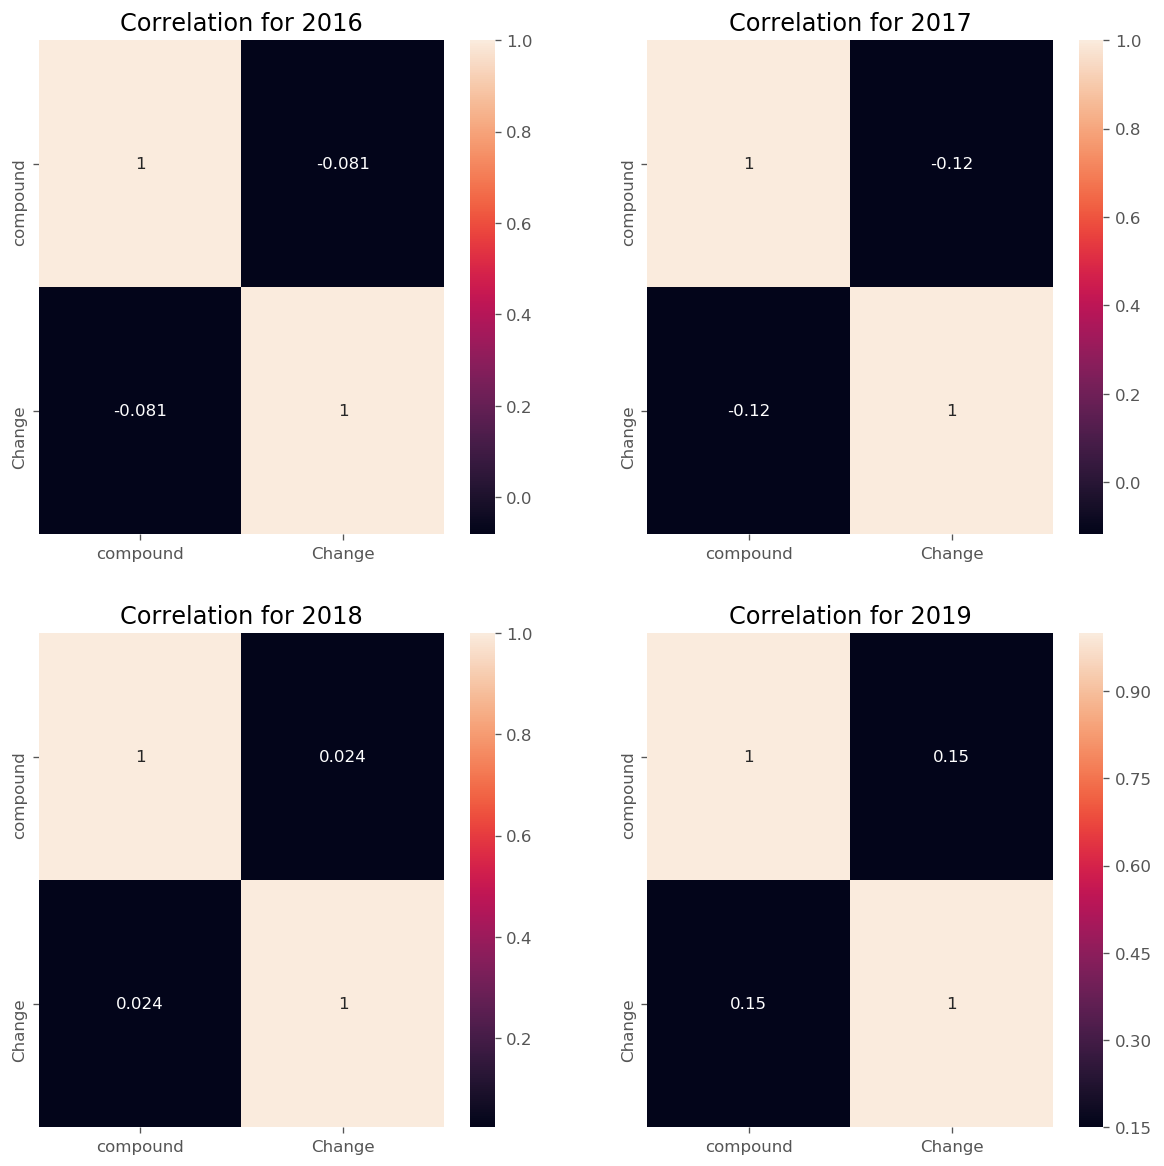

In [76]:
import seaborn as sns
fig, ax = plt.subplots(2, 2)
plt.rcParams['figure.figsize']=(12,12)
sns.heatmap(corr_2016, annot=True,ax=ax[0][0])
ax[0][0].set_title("Correlation for 2016")
sns.heatmap(corr_2017, annot=True,ax=ax[0][1])
ax[0][1].set_title("Correlation for 2017")
sns.heatmap(corr_2018, annot=True,ax=ax[1][0])
ax[1][0].set_title("Correlation for 2018")
sns.heatmap(corr_2019, annot=True,ax=ax[1][1])
ax[1][1].set_title("Correlation for 2019")

In [74]:
data_merged_scores.groupby('Date')[['compound','Change']].mean().corr()

,compound,Change
compound,1.000000000,0.009788182
Change,0.009788182,1.000000000


In [75]:
data_merged_scores.groupby('Date')[['compound','Difference']].mean().corr()

,compound,Difference
compound,1.000000000,0.017457123
Difference,0.017457123,1.000000000


We have to be also aware of the fact that the number of observations also decreased.

From this result we can see that during the presidential campaign and most recent tweets have this far the the highest association between the S&P 500 index change and the sentiment of the tweets. This means, we can see a pattern, however, it is still not high enough to make conclusions.

Thus, we need more complex and multidimensional  model. The next section will be directed on the construction of the Recurrent Neural Network for the purpose of index/stock price changes using the tweet texts as an input. 

# 3. Construct RNN (Recurrent Neural Network) for the prediction of closing stock price percentage change based on the tweet texts

In [77]:
df=df[['Date','text','Difference']]
df.head(2)

,Date,text,Difference
0,2019-10-11,RT @WhiteHouse: ? 13000 new construction jobs?...,32.140137000
1,2019-10-11,RT @WhiteHouse: USMCA updates NAFTA to achieve...,32.140137000


Before proceeding to the construction of the network, I need to prepare the dataset. First I create two binary variables, both based on the values of the "Change" column. If the change in the index price is non-negative I assign the value of 1 in case of "Binary" and "positive" in case of "Binary_text" variable. All negative values are assigned 0 ("Negative").   

In [78]:
df['Binary_text'] = ['Positive' if x >=0 else 'Negative' for x in df['Difference']] 
df['Binary'] = [1 if x >=0 else 0 for x in df['Difference']] 
df.head(2)

,Date,text,Difference,Binary_text,Binary
0,2019-10-11,RT @WhiteHouse: ? 13000 new construction jobs?...,32.140137000,Positive,1
1,2019-10-11,RT @WhiteHouse: USMCA updates NAFTA to achieve...,32.140137000,Positive,1


In [79]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

pmdarima==1.2.1
plotly==4.0.0
wordcloud==1.5.0
vaderSentiment==3.2.1
textblob==0.15.3
statsmodels==0.10.1
seaborn==0.9.0
pandas==0.23.4
numpy==1.16.4
nltk==3.3
matplotlib==3.0.3
